## 주식 예측에 도전해 보자  
### ARIMA를 이용한 시계열 데이터 예측
종가 기준 시계열 데이터를 예측한다  

step 1. 시계열 데이터 준비  
과제의 요구사항은 '종가'를 예측하는 것이다.   

In [1]:
# 필요 모듈 import
import pandas as pd
import numpy as np
import sklearn
import statsmodels
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터 경로에서 파일 불러오기
data_path='.\ess_data\ARIMA_stock_prediction'
sam_path=os.path.join(data_path, '005930KS.csv')
sam_data=pd.read_csv(sam_path, index_col='Date')
print(sam_data.shape)
sam_data.head(10)

(250, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
2020-05-25,48750.0,48900.0,48450.0,48850.0,46836.773438,14337913
2020-05-26,48700.0,49450.0,48600.0,49250.0,47220.289063,15127490
2020-05-27,48950.0,50000.0,48800.0,49900.0,47843.500000,19548479
2020-05-28,51100.0,51200.0,49900.0,50400.0,48322.898438,31309318


In [3]:
sam_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7+ KB


step2. 각종 전처리 수행  
결측값, 중복값 확인, 처리 및 그래프 관찰과 로그 변환을 진행하였다.

In [4]:
# 결측값 확인
sam_close=sam_data['Close']
sam_close.isna().sum()

0

In [5]:
# 중복값 확인
sam_data.duplicated()[sam_data.duplicated()==True]

Series([], dtype: bool)

<AxesSubplot:xlabel='Close', ylabel='Density'>

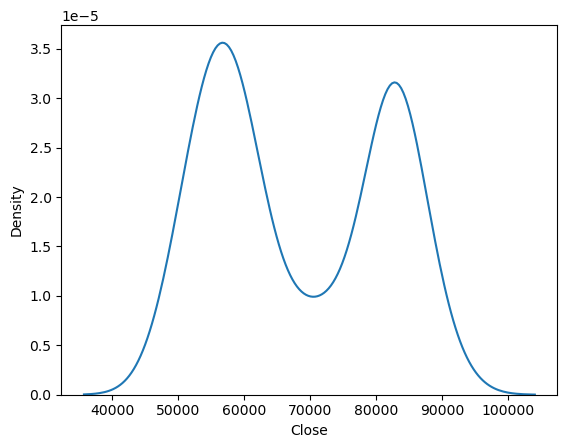

In [6]:
# 그래프 그리기: close만 실행
sns.kdeplot(sam_close)

In [7]:
print(sam_close.skew())
print(sam_close.kurt())

0.15618549819653754
-1.6353091861844875


데이터의 왜도(skewness)와 첨도(kurtosis)를 구하였을 때, 둘 다 절대값이 크지 않으며, 위와 같은 형태의 분포에 적용하는 것을 확인하기 어려워 log는 적용하지 않았다.

step 3. 시계열 안정성 분석  
시계열 data가 얼마나 starionary한지 확인하기 위해 정성적 그래프 분석부터 시작하였다.  

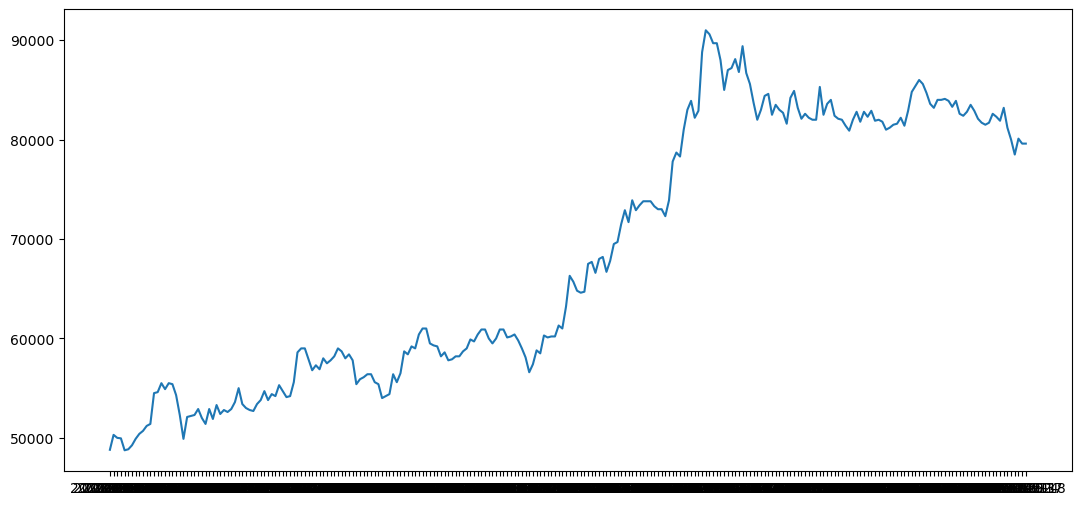

In [8]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  
plt.plot(sam_close)

In [9]:
def plot_rolling_statistics(timeseries, window=5):
    rolmean= timeseries.rolling(window=window).mean()
    rolstd= timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

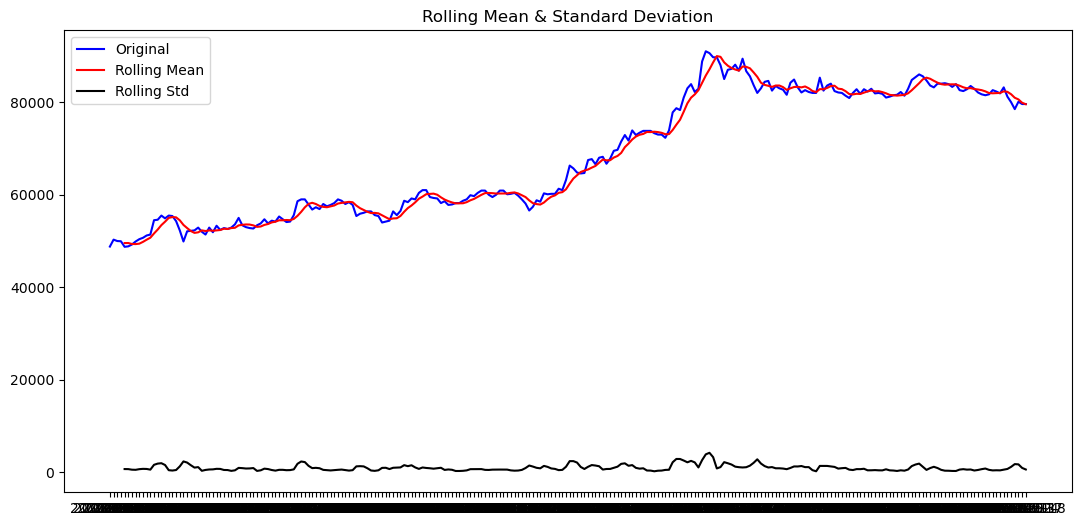

In [10]:
plot_rolling_statistics(sam_close, window=5)

그래프로 확인해 보았을 때, 시간의 흐름에 따라 이동표준편차는 다소 안정적으로 보여지나, 이동평규는 증가하다가 감소하는 추세를 보이고 있다. 그러므로 삼성전자의 주가는 stationary 하다고 보기는 어려울 것 같다.  
좀 더 정밀한 판단을 위하여, adf test를 시행하고 p 값을 확인해 보기로 하였다.  


In [11]:
from statsmodels.tsa.stattools import adfuller

# 
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(sam_close)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


adf test의 p-value값은 0.6637로 stationary와는 거리가 먼 값을 보였다. 값을 더욱 안정시키기 위해

시계열 분해(Time Series Decomposition)  
Residual 안정성 확인  

In [13]:
sam_log=np.log1p(sam_close)

In [14]:
augmented_dickey_fuller_test(sam_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383522
p-value                          0.590150
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


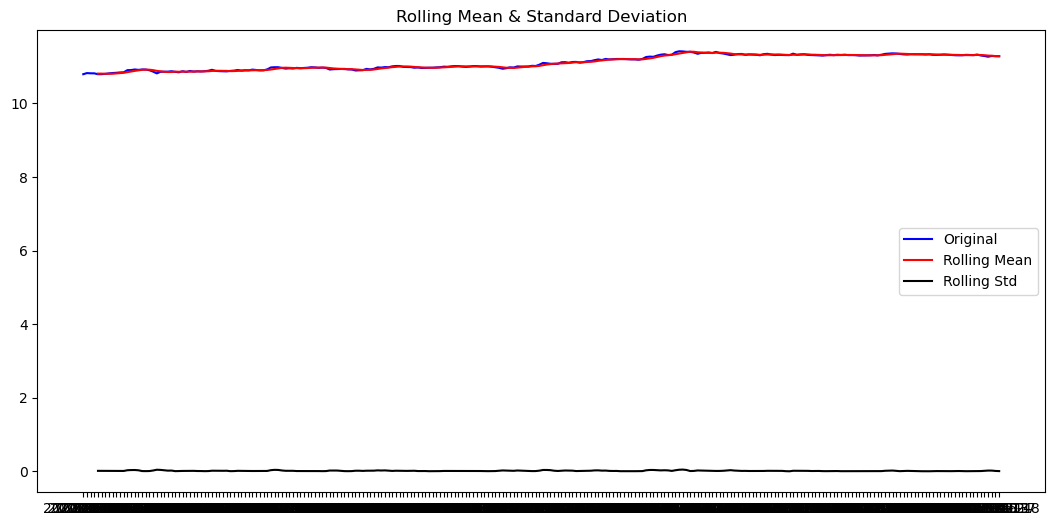

In [15]:
plot_rolling_statistics(sam_log, window=5)

0.07정도 p-value가 줄어들었다. 물론 skewness나 kurtosis가 높지 않았기 때문에 두 값을 수정하여 p-value를 높이는 로그 적용은 p-value에 큰 영향을 미치지 못하는 것 같다. 그래프로 보았을 때는 상당히 일정해 보이기는 하지만 시각적 판단보다는 p-value가 더 정확하다고 보았기 때문에 추가로 trend(추세)를 상쇄하여 p-value를 좀 더 줄여보기로 하였다.

In [16]:
# sam_log에서 이동평균값을 빼주면 추세를 상쇄시킬 수 있다.
sam_log_mov_avg=sam_log-sam_log.rolling(window=5).mean()
# 이동평균 빼주며 발생하는 NaN값 제거
sam_log_mov_avg.dropna(inplace=True)

In [17]:
augmented_dickey_fuller_test(sam_log_mov_avg)

Results of Dickey-Fuller Test:
Test Statistic                -7.801632e+00
p-value                        7.466391e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


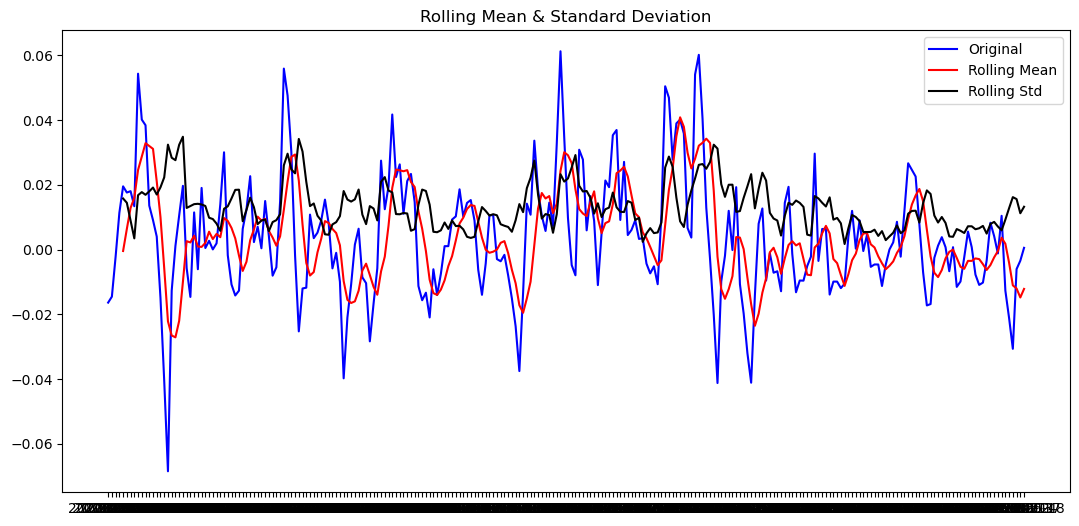

In [18]:
plot_rolling_statistics(sam_log_mov_avg, window=5)

압도적으로 p-value가 줄은 것을 확인할 수 있었다. 7.466391e-12=7.466391*(10**(-12))로 상당히 작은 값이로 변하였으며, 그래프상으로는 아까보다 상당히 어지러워 보이지만 y축의 단위를 보면 전보다 훨씬 stationary하다고 할 수 있다. 이 정도만 하더라도 충분히 stationary 하지만 배우는 입장에서 차분을 추가로 실시하여 더욱 stationary 하게 변환시킬 수 있는지 확인해 보았다.  

In [19]:
sam_log_mov_avg_shift=sam_log_mov_avg.shift(-1)
sam_log_mov_avg_shift.dropna(inplace=True)
augmented_dickey_fuller_test(sam_log_mov_avg_shift)

Results of Dickey-Fuller Test:
Test Statistic                -7.648103e+00
p-value                        1.819724e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


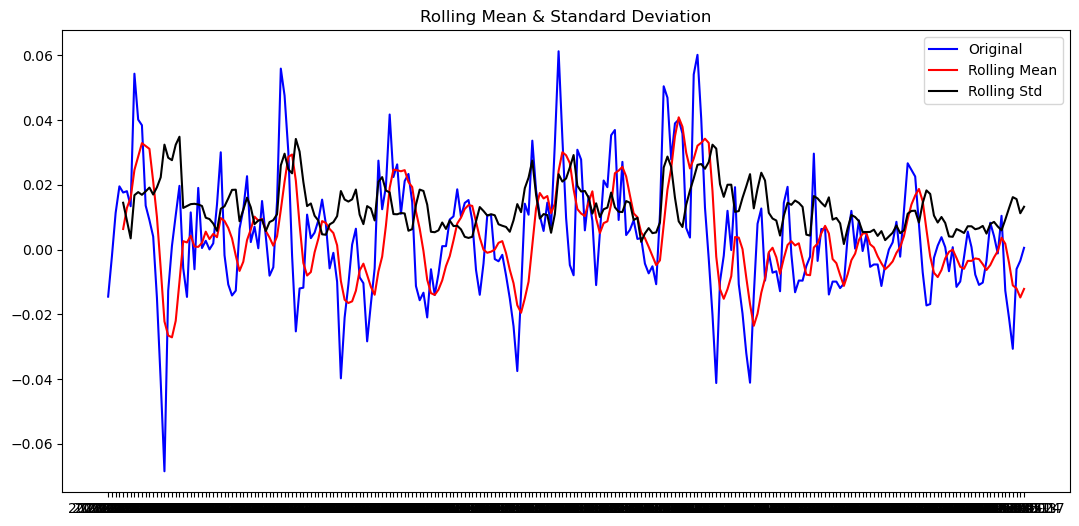

In [20]:
plot_rolling_statistics(sam_log_mov_avg_shift, window=5)

차분까지 실행한 결과, 오히려 p-value는 다시 높아졌고, 시각적으로 비교하여도 그래프는 더욱 요동치기 시작하였다. 이미 충분히 stationary하게 만들었음에도 차분을 추가로 적용할 때 오히려 역효과를 내는 것을 확인할 수 있었다.

step 4. 학습, 테스트 데이터셋 생성  

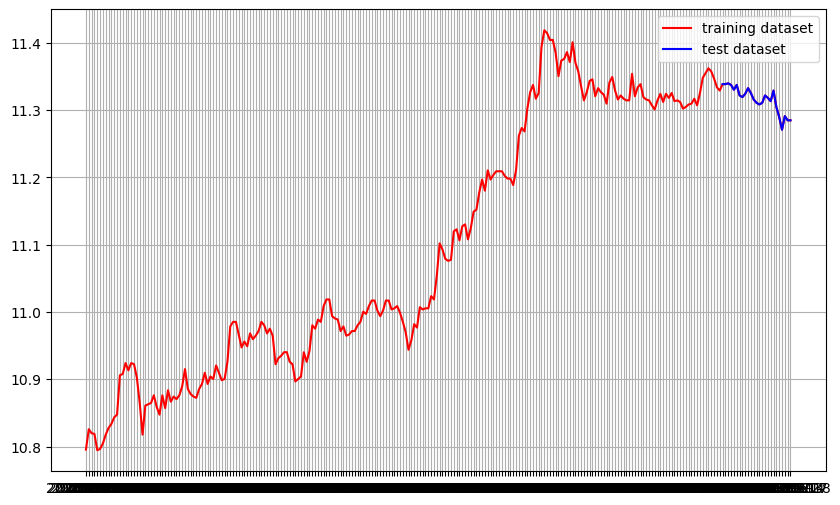

In [21]:
train_data, test_data = sam_log[:int(len(sam_log)*0.9)], sam_log[int(len(sam_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sam_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

step 5. 적정 ARIMA 모수 찾기 ACF, PACF구해보기  
->p, q 구하기 및 차분 안정성 확인하여 d구하기  
시각적으로 확인하는 방식을 사용하기 위해 ACF와 PACF그래프를 그린다.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


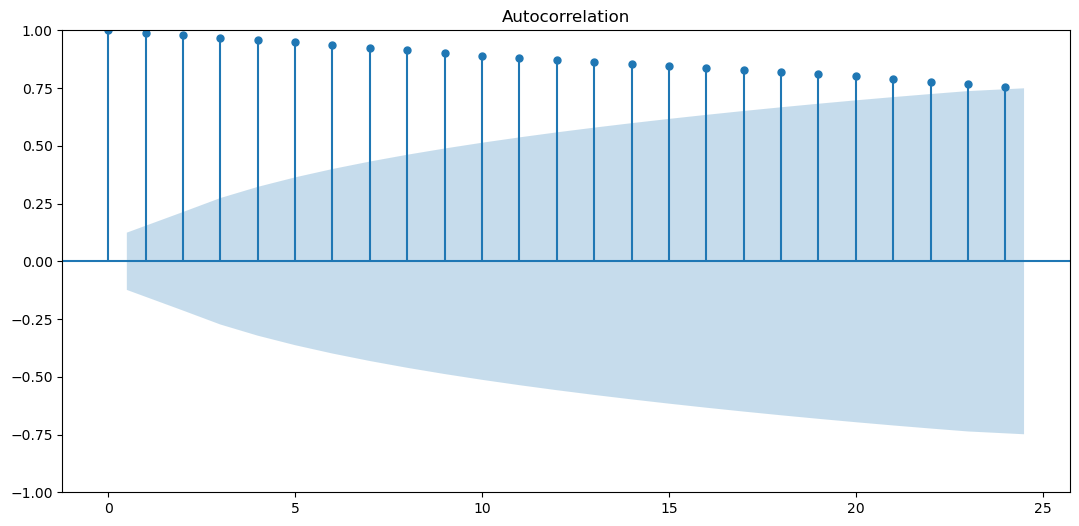

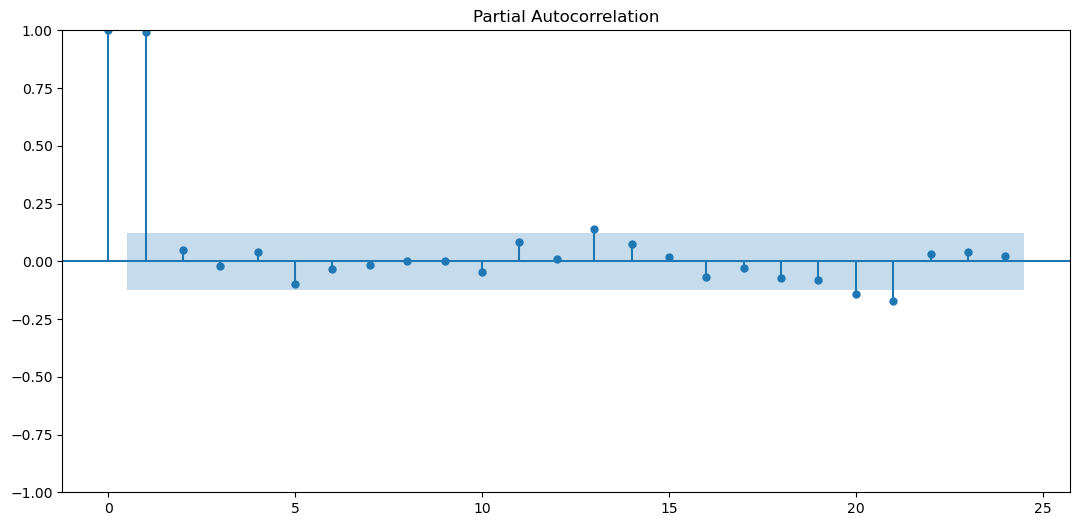

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sam_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(sam_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 지수적으로, PACF는 1시차 이후 0에 가까운 die out 현상을 보였다. 이 경우 AR을 사용하고 (p=1, q=0)으로 값을 두어 진행해야 할 것으로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553698e+01
p-value                        2.183755e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


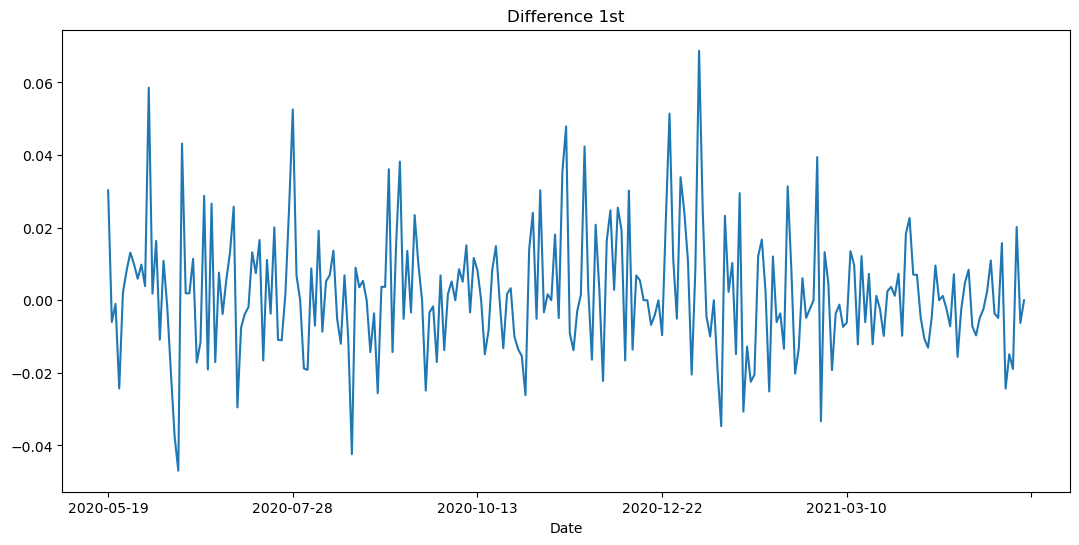

In [23]:
diff_1 = sam_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029321e+01
p-value                        3.525693e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


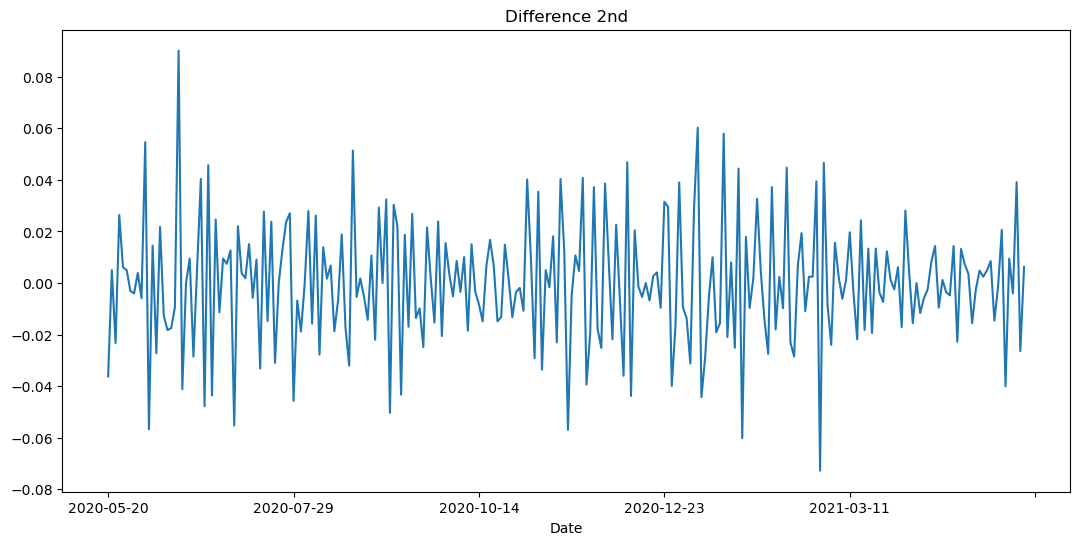

In [24]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

차분 결과, 1차 차분의 결과가 좀 더 안정적이라고 할 수 있기 때문에, d=1로 시도해 보도록 한다.

step 6. ARIMA 모델 훈련과 테스트  

In [25]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.492
Date:                Tue, 22 Nov 2022   AIC                          -1162.983
Time:                        03:55:36   BIC                          -1156.160
Sample:                             0   HQIC                         -1160.229
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

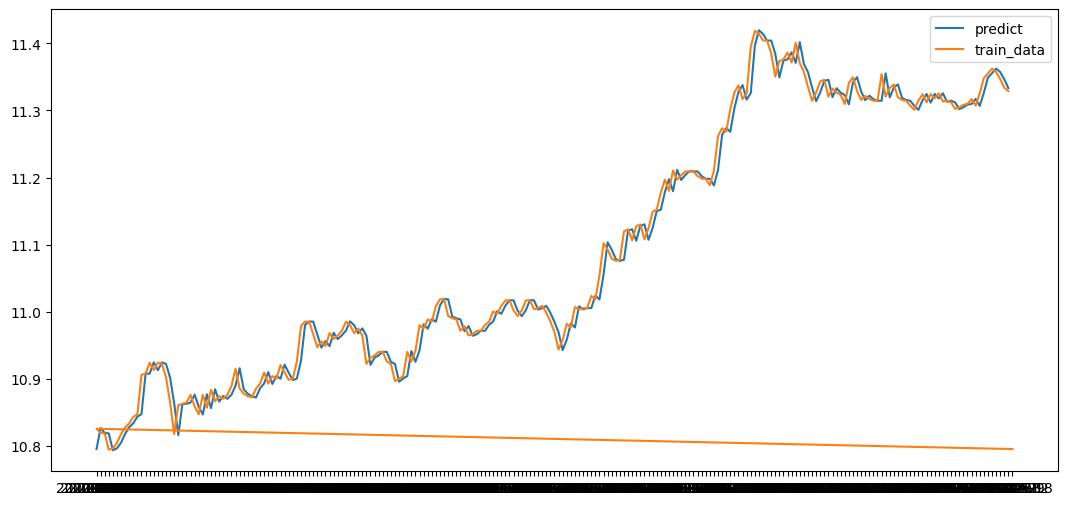

In [26]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

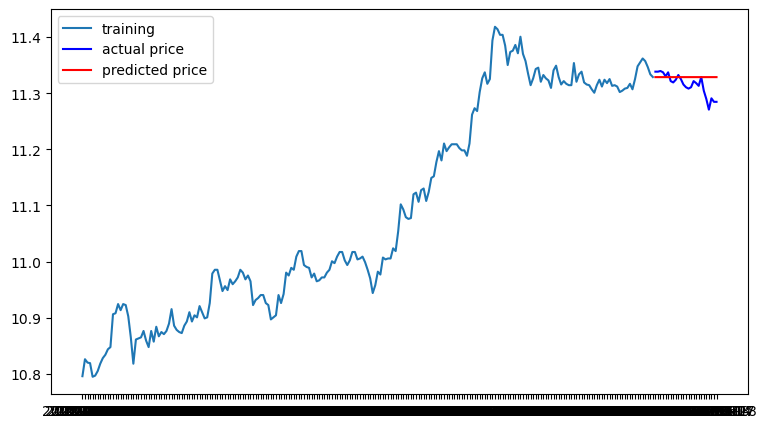

In [27]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc) 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.expm1(test_data), np.expm1(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.expm1(test_data), np.expm1(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.expm1(test_data), np.expm1(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.expm1(fc) - np.expm1(test_data))/np.abs(np.expm1(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.5558411293
MAE:  1403.0336905541324
RMSE:  1865.613452953513
MAPE: 1.74%


데이터 분석 결과, MAPE 1.74%로 준수한 숫자가 나왔다. 하지만 예측 결과의 그래프는 수평이었기 때문에 도대체 어떤 값들이 들어가 있는지 확인해 보지 않을 수 없었다.

In [29]:
fc

array([11.32885496, 11.32884964, 11.32884946, 11.32884946, 11.32884946,
       11.32884946, 11.32884946, 11.32884946, 11.32884946, 11.32884946,
       11.32884946, 11.32884946, 11.32884946, 11.32884946, 11.32884946,
       11.32884946, 11.32884946, 11.32884946, 11.32884946, 11.32884946,
       11.32884946, 11.32884946, 11.32884946, 11.32884946, 11.32884946])

예측값 맨 앞의 몇몇 값들을 제외하고는 같은 값들이 들어가 있는 것을 확인하였다. 왜 이렇게 나오는지 고민해 보고 매개변수도 잘못된 것은 없는지 여러번 확인해 보았지만 뾰족한 이유를 확인할 수 없었다. 안타깝지만 시간 문제로 다른 데이터들에 대하여 같은 방식으로 데이터를 분석해 보기로 마음먹었다.

#### 삼성전자 외 데이터 분석
1) LS ELECTRIC

In [30]:
# 데이터 경로에서 파일 불러오기
data_path='.\ess_data\ARIMA_stock_prediction'
ls_path=os.path.join(data_path, 'ls_electric_stock.csv')
ls_data=pd.read_csv(ls_path) #, index_col='일자'
print(ls_data.shape)

ls_data.head(5)

(742, 11)


,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2022/11/21,56000,300,0.54,56300,57300,55500,142269,8020231300,1680000000000,30000000
1,2022/11/18,55700,1000,1.83,54800,56400,54200,146164,8162820300,1671000000000,30000000
2,2022/11/17,54700,-1200,-2.15,56200,57900,54700,123582,6951346300,1641000000000,30000000
3,2022/11/16,55900,3000,5.67,52800,56500,52800,200519,11011218600,1677000000000,30000000
4,2022/11/15,52900,-600,-1.12,53100,53800,52300,107743,5717278900,1587000000000,30000000


In [31]:
ls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      742 non-null    object 
 1   종가      742 non-null    int64  
 2   대비      742 non-null    int64  
 3   등락률     742 non-null    float64
 4   시가      742 non-null    int64  
 5   고가      742 non-null    int64  
 6   저가      742 non-null    int64  
 7   거래량     742 non-null    int64  
 8   거래대금    742 non-null    int64  
 9   시가총액    742 non-null    int64  
 10  상장주식수   742 non-null    int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 63.9+ KB


In [32]:
# '일자'의 type을 datetime 변경
ls_data['일자'] = pd.to_datetime(ls_data['일자'])
ls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      742 non-null    datetime64[ns]
 1   종가      742 non-null    int64         
 2   대비      742 non-null    int64         
 3   등락률     742 non-null    float64       
 4   시가      742 non-null    int64         
 5   고가      742 non-null    int64         
 6   저가      742 non-null    int64         
 7   거래량     742 non-null    int64         
 8   거래대금    742 non-null    int64         
 9   시가총액    742 non-null    int64         
 10  상장주식수   742 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(9)
memory usage: 63.9 KB


결측값은 없는 것으로 확인됨(742 index존재, 742 non-null)

In [33]:
# 중복값 확인
ls_data.duplicated()[ls_data.duplicated()==True]

Series([], dtype: bool)

In [34]:
# 종가만 추출, index를 일자로 변경
ls_close=ls_data['종가'].rename(index=ls_data['일자'])

In [35]:
ls_close=ls_close.sort_index(ascending=True)

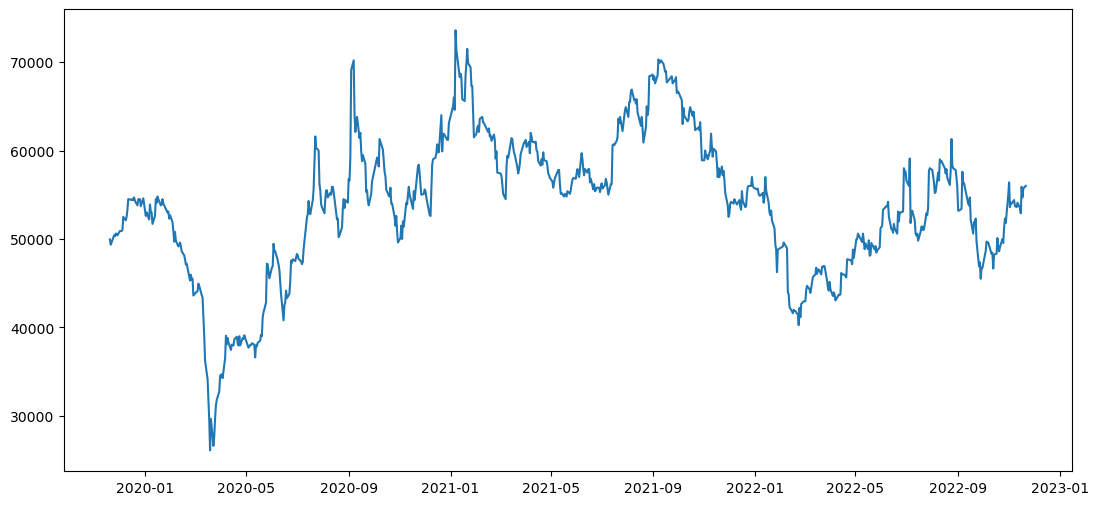

In [36]:
# 추세 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  
plt.plot(ls_close)

In [37]:
# 종가데이터 adf test 시행
augmented_dickey_fuller_test(ls_close)

Results of Dickey-Fuller Test:
Test Statistic                  -2.286010
p-value                          0.176520
#Lags Used                       6.000000
Number of Observations Used    735.000000
Critical Value (1%)             -3.439278
Critical Value (5%)             -2.865480
Critical Value (10%)            -2.568868
dtype: float64


p-value값이 0.189630으로, 추가 log화를 진행하였다.

In [38]:
ls_log=np.log1p(ls_close)

In [39]:
augmented_dickey_fuller_test(ls_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.452092
p-value                          0.127570
#Lags Used                       6.000000
Number of Observations Used    735.000000
Critical Value (1%)             -3.439278
Critical Value (5%)             -2.865480
Critical Value (10%)            -2.568868
dtype: float64


한번 직접 시계열을 분해해 보았기 때문에 seasonal_decompose 함수를 사용하여 시계열을 분해하였다.

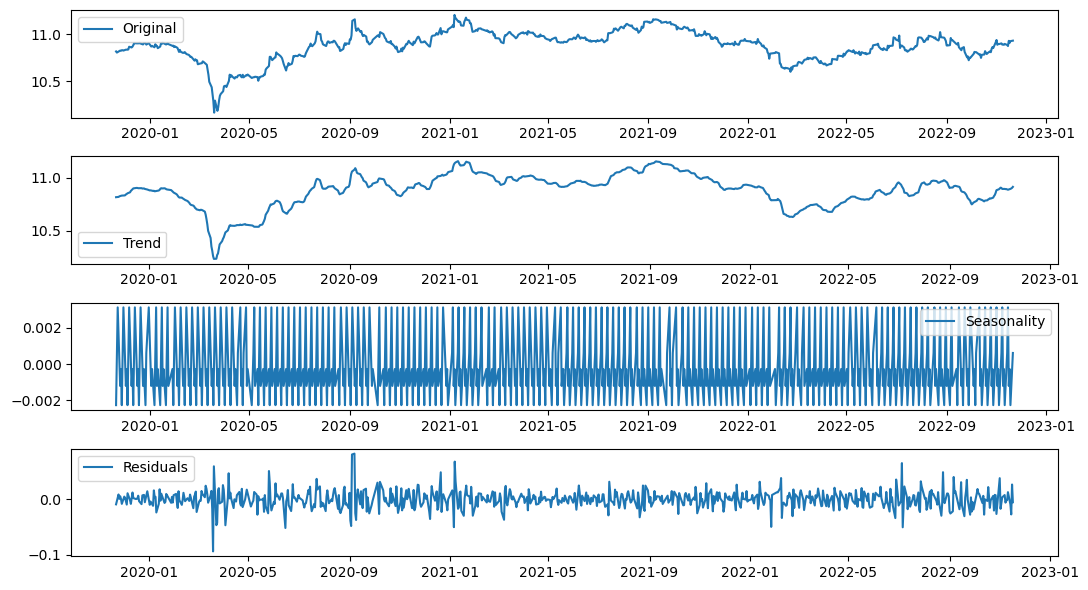

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ls_log, period=5) # 5일마다 변한다고 가정하였다.



trend = decomposition.trend # 추세
seasonal = decomposition.seasonal # 계절성
residual = decomposition.resid # 잔차

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ls_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

테스트 데이터 분리

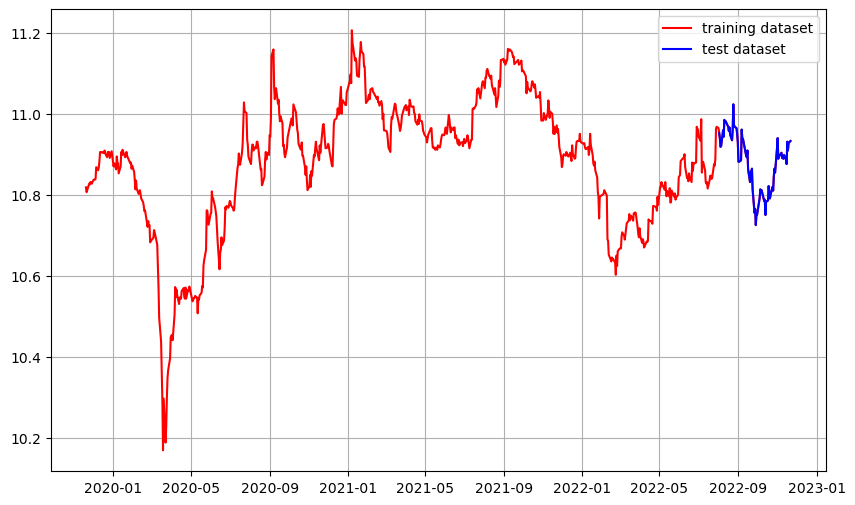

In [41]:
train_data, test_data = ls_log[:int(len(ls_log)*0.9)], ls_log[int(len(ls_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ls_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

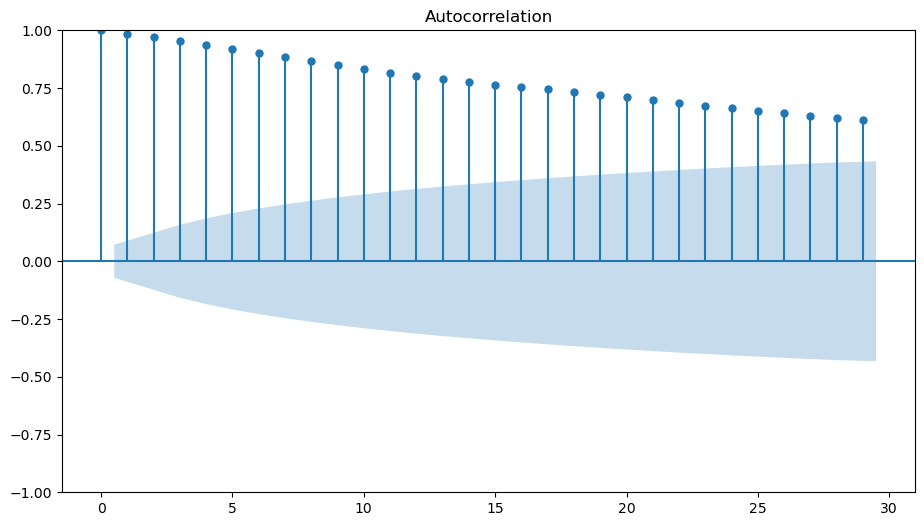

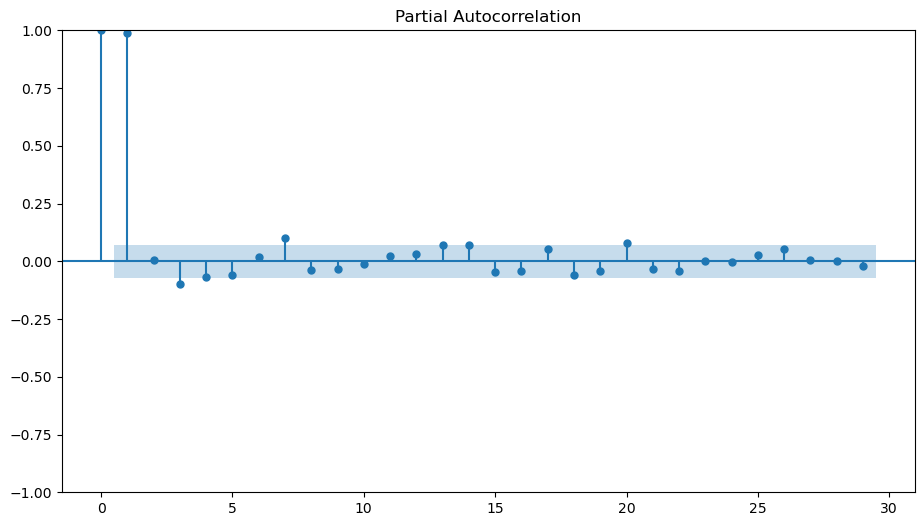

In [42]:
plot_acf(ls_log)
plot_pacf(ls_log)
plt.show()

ACF는 지수적으로, PACF는 1시차 이후 0에 가까운 die out 현상을 보였다. 지나치다 싶을 정도로 삼성전자와 비슷한 형태의 ACF와 PACF를 가지고 있으며, 삼성전자와 마찬가지로 AR을 사용하고 (p=1, q=0)으로 값을 두어 진행해야 할 것으로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.135828e+01
p-value                        9.613332e-21
#Lags Used                     5.000000e+00
Number of Observations Used    7.350000e+02
Critical Value (1%)           -3.439278e+00
Critical Value (5%)           -2.865480e+00
Critical Value (10%)          -2.568868e+00
dtype: float64


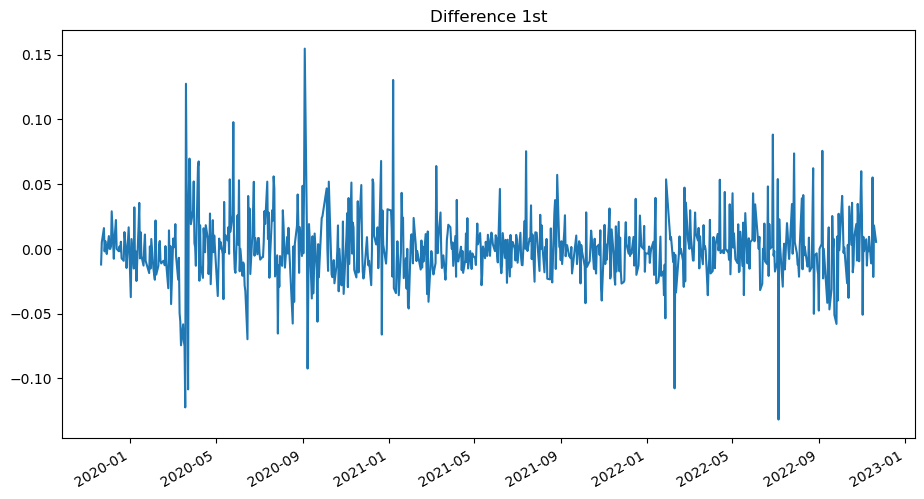

In [43]:
diff_1 = ls_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.088002e+01
p-value                        1.301944e-19
#Lags Used                     1.900000e+01
Number of Observations Used    7.200000e+02
Critical Value (1%)           -3.439465e+00
Critical Value (5%)           -2.865563e+00
Critical Value (10%)          -2.568912e+00
dtype: float64


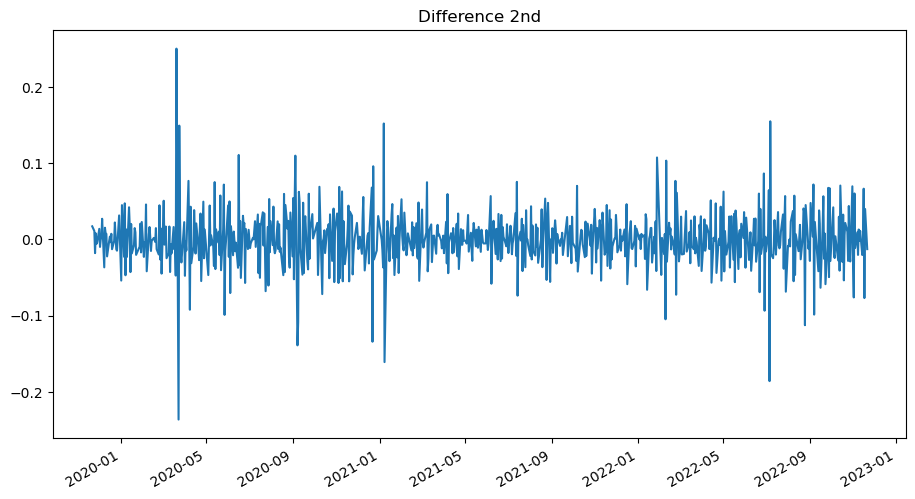

In [44]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

차분 결과는 1차가 더 안정적이기 때문에 d=1으로 진행하도록 하였다.

In [45]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                  667
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1477.851
Date:                Tue, 22 Nov 2022   AIC                          -2951.701
Time:                        03:55:47   BIC                          -2942.699
Sample:                             0   HQIC                         -2948.213
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       -7.39e-05      0.022     -0.003      0.997      -0.044       0.044
sigma2         0.0007   1.92e-05     36.087      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

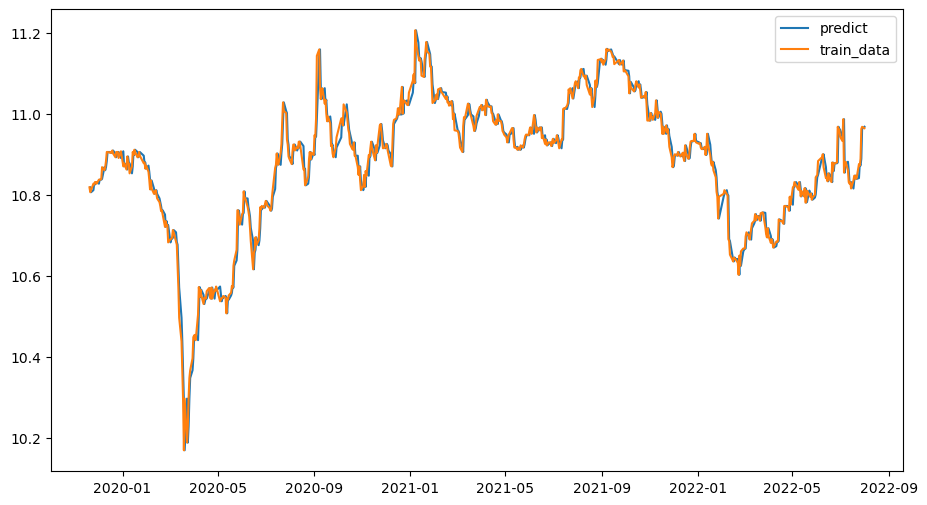

In [46]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

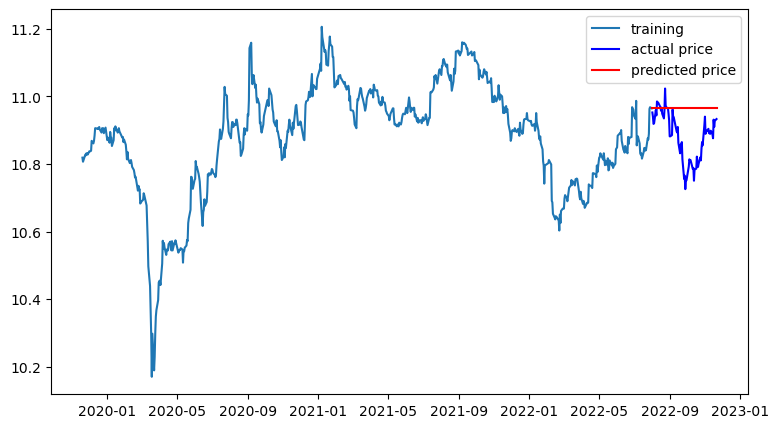

In [47]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc) 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.expm1(test_data), np.expm1(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.expm1(test_data), np.expm1(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.expm1(test_data), np.expm1(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.expm1(fc) - np.expm1(test_data))/np.abs(np.expm1(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  33553497.85018751
MAE:  4648.678272339748
RMSE:  5792.538118147131
MAPE: 9.21%


In [49]:
fc

array([10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96476161,
       10.96476161, 10.96476161, 10.96476161, 10.96476161, 10.96

또 같은 결과다. 무엇이 문제인가? MAPE 값은 맞췄지만 무언가 확실히 잘못되었다.

2) SK HYNIX

In [50]:
# 데이터 경로에서 파일 불러오기
data_path='.\ess_data\ARIMA_stock_prediction'
sk_path=os.path.join(data_path, 'sk_hynix_stock.csv')
sk_data=pd.read_csv(sk_path) #, index_col='일자'
print(sk_data.shape)

sk_data.head(5)

(742, 11)


,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2022/11/21,86300,-2100,-2.38,87600,87700,86100,2111523,182763598700,62826604099500,728002365
1,2022/11/18,88400,700,0.80,88700,91500,88100,2981192,267105986700,64355409066000,728002365
2,2022/11/17,87700,-3800,-4.15,82400,88500,82000,3703870,323608613600,63845807410500,728002365
3,2022/11/16,91500,-100,-0.11,92000,92400,90300,2609199,238677656700,66612216397500,728002365
4,2022/11/15,91600,700,0.77,91300,92100,90400,2460465,224722829263,66685016634000,728002365


In [51]:
sk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      742 non-null    object 
 1   종가      742 non-null    int64  
 2   대비      742 non-null    int64  
 3   등락률     742 non-null    float64
 4   시가      742 non-null    int64  
 5   고가      742 non-null    int64  
 6   저가      742 non-null    int64  
 7   거래량     742 non-null    int64  
 8   거래대금    742 non-null    int64  
 9   시가총액    742 non-null    int64  
 10  상장주식수   742 non-null    int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 63.9+ KB


결측값 없음 확인, 이후 전처리 과정은 데이터 출처가 같기 때문에 같은 방식으로 진행되고, 데이터 stationary 관련 확인도 같은 방식으로 진행된다.

In [52]:
# '일자'의 type을 datetime 변경
sk_data['일자'] = pd.to_datetime(sk_data['일자'])
sk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      742 non-null    datetime64[ns]
 1   종가      742 non-null    int64         
 2   대비      742 non-null    int64         
 3   등락률     742 non-null    float64       
 4   시가      742 non-null    int64         
 5   고가      742 non-null    int64         
 6   저가      742 non-null    int64         
 7   거래량     742 non-null    int64         
 8   거래대금    742 non-null    int64         
 9   시가총액    742 non-null    int64         
 10  상장주식수   742 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(9)
memory usage: 63.9 KB


In [53]:
# 중복값 확인
sk_data.duplicated()[sk_data.duplicated()==True]

Series([], dtype: bool)

In [54]:
# 종가만 추출, index를 일자로 변경
sk_close=sk_data['종가'].rename(index=sk_data['일자'])

In [55]:
sk_close=sk_close.sort_index(ascending=True)

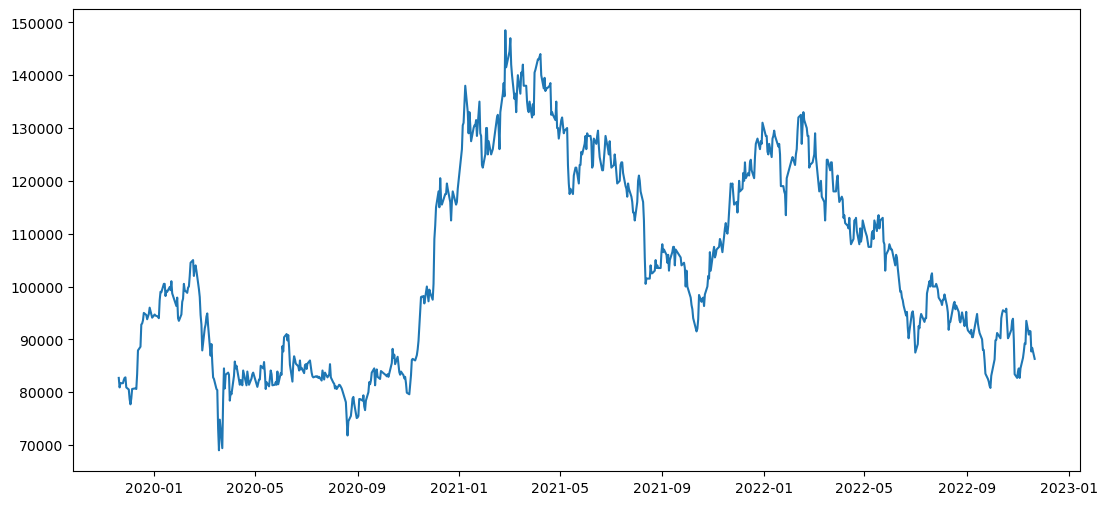

In [56]:
rcParams['figure.figsize'] = 13, 6  
plt.plot(sk_close)

In [57]:
# 종가데이터 adf test 시행
augmented_dickey_fuller_test(sk_close)

Results of Dickey-Fuller Test:
Test Statistic                  -1.842857
p-value                          0.359401
#Lags Used                       0.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


log화 진행

In [58]:
sk_log=np.log1p(sk_close)

In [59]:
augmented_dickey_fuller_test(sk_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.862152
p-value                          0.350070
#Lags Used                       0.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


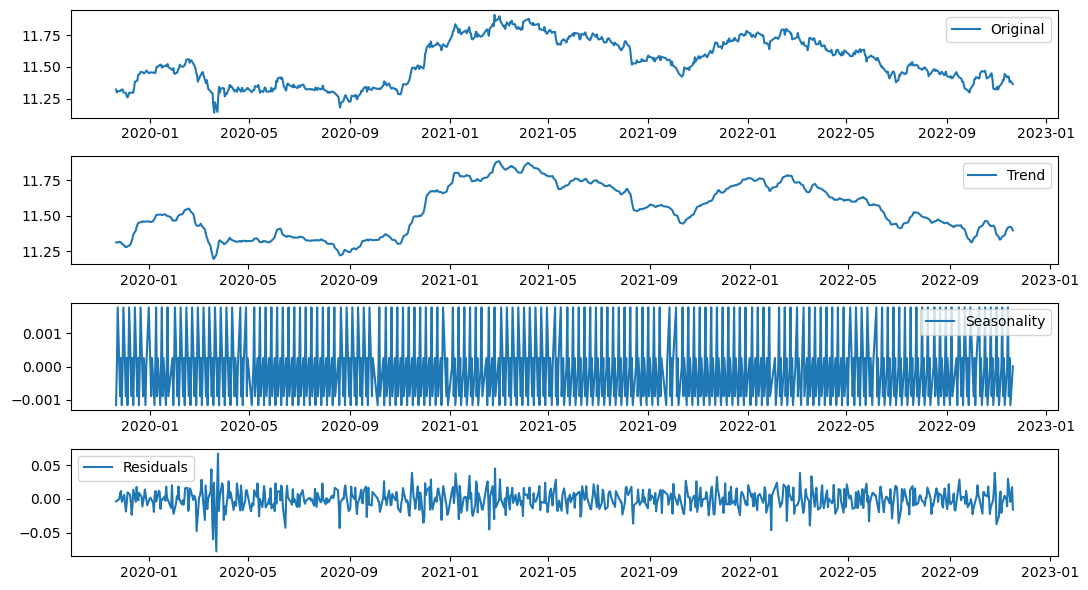

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sk_log, period=5) # 5일마다 변한다고 가정하였다.



trend = decomposition.trend # 추세
seasonal = decomposition.seasonal # 계절성
residual = decomposition.resid # 잔차

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(sk_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

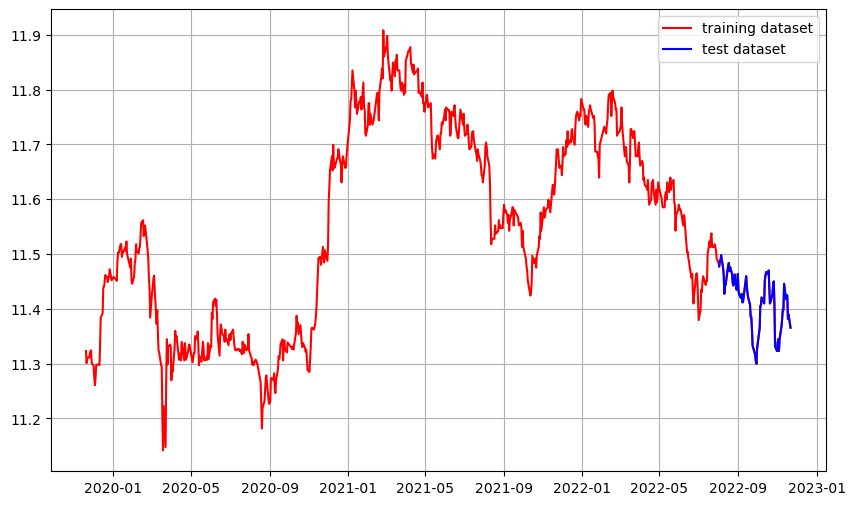

In [61]:
train_data, test_data = sk_log[:int(len(sk_log)*0.9)], sk_log[int(len(sk_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sk_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

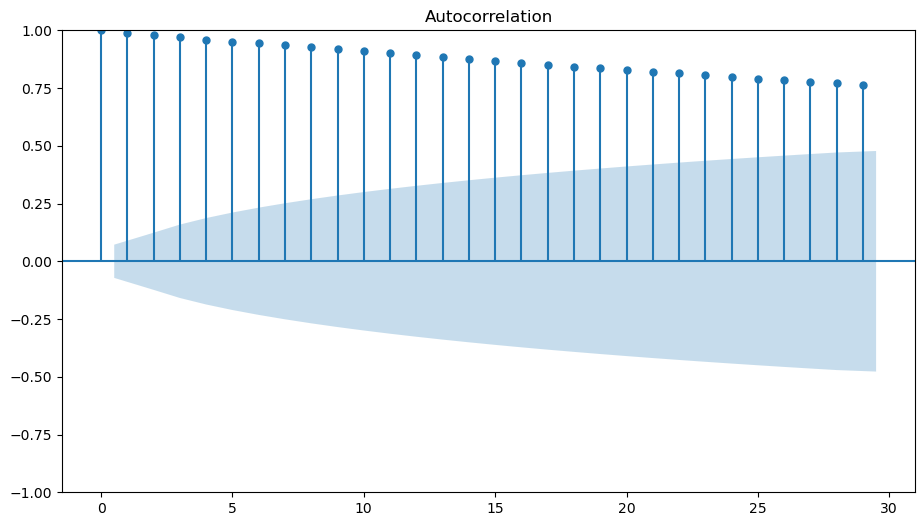

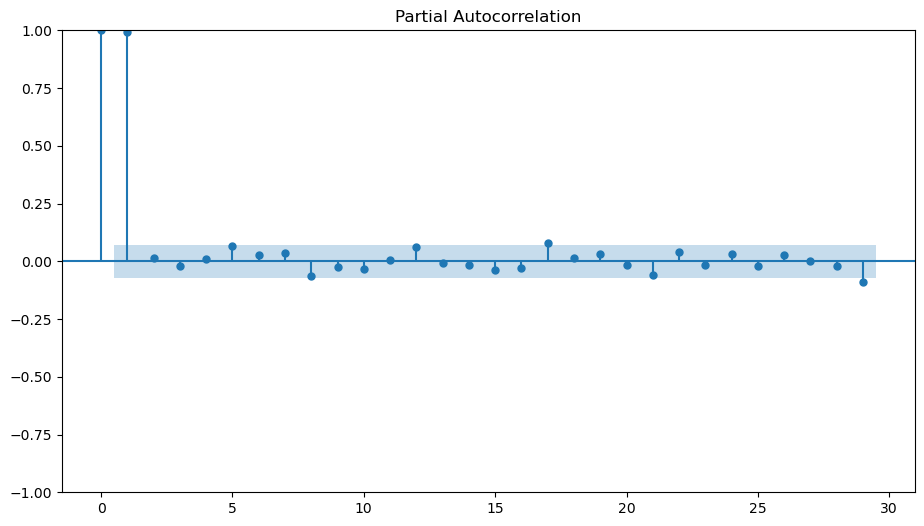

In [62]:
plot_acf(sk_log)
plot_pacf(sk_log)
plt.show()

삼성전자나 LS와 대동소이하다. AR을 사용하고 (p=1, q=0)으로 값을 두어 진행할 것이다.

Results of Dickey-Fuller Test:
Test Statistic                 -27.732163
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    740.000000
Critical Value (1%)             -3.439218
Critical Value (5%)             -2.865454
Critical Value (10%)            -2.568854
dtype: float64


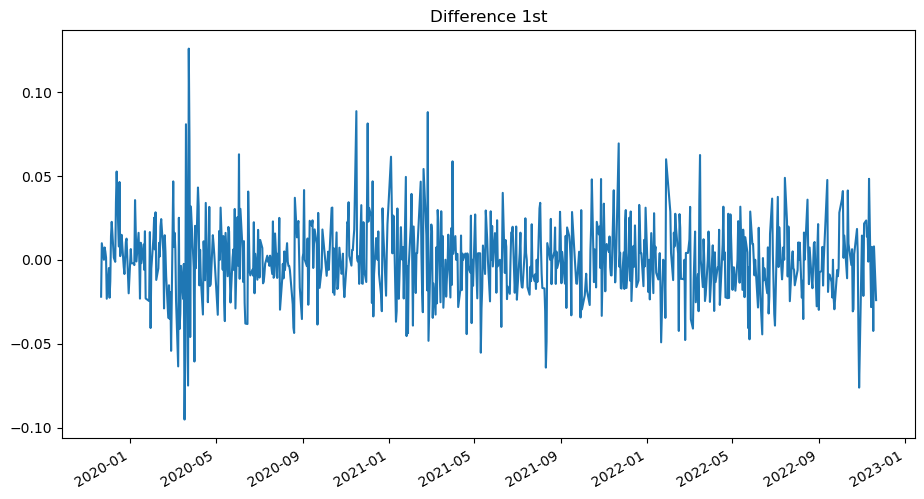

In [63]:
diff_1 = sk_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.082084e+01
p-value                        1.807315e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.190000e+02
Critical Value (1%)           -3.439478e+00
Critical Value (5%)           -2.865568e+00
Critical Value (10%)          -2.568915e+00
dtype: float64


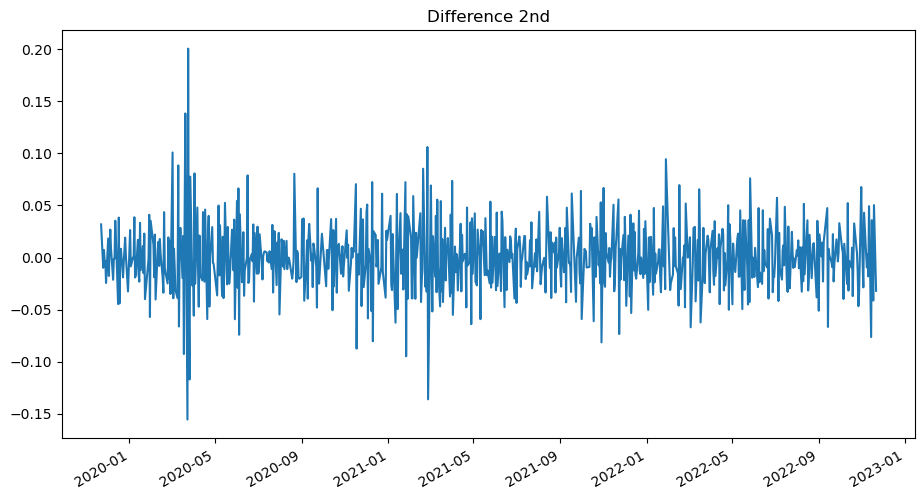

In [64]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차가 0이라는.... 놀라운 수가 나왔기 때문에 d=1이다.

In [65]:
warnings.filterwarnings('ignore') 

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                     종가   No. Observations:                  667
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1554.053
Date:                Tue, 22 Nov 2022   AIC                          -3104.107
Time:                        04:00:15   BIC                          -3095.104
Sample:                             0   HQIC                         -3100.619
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0378      0.026     -1.473      0.141      -0.088       0.012
sigma2         0.0006   2.12e-05     25.938      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

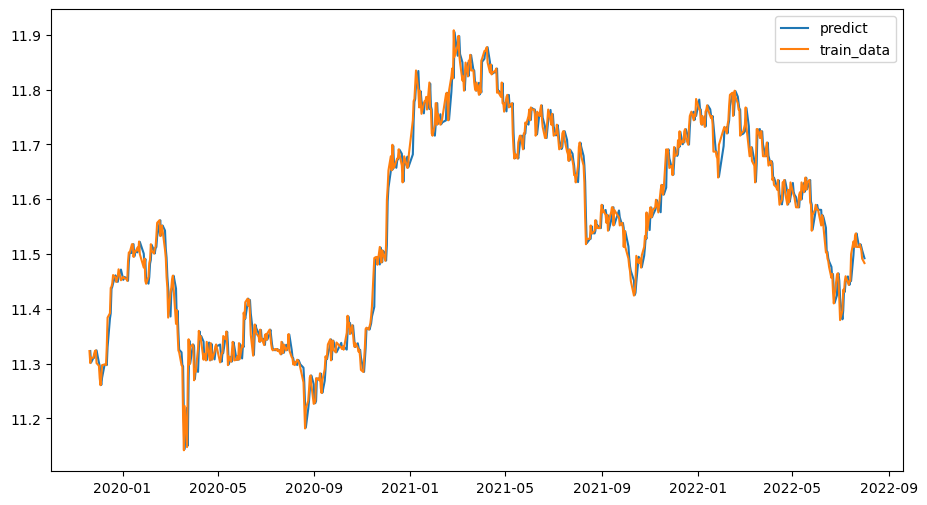

In [66]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

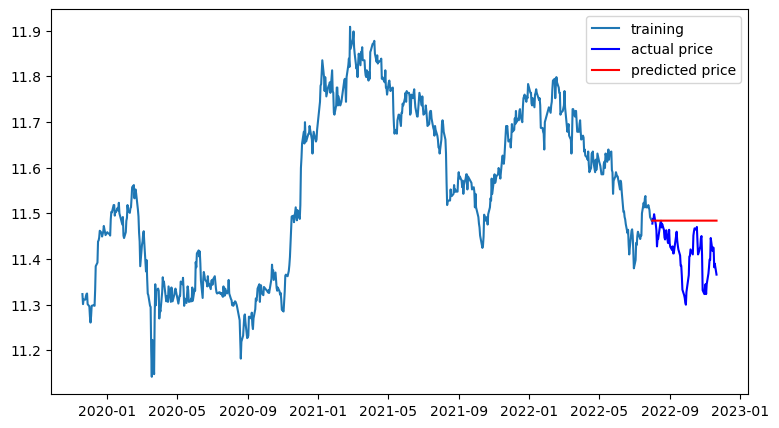

In [67]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc) 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.expm1(test_data), np.expm1(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.expm1(test_data), np.expm1(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.expm1(test_data), np.expm1(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.expm1(fc) - np.expm1(test_data))/np.abs(np.expm1(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  60005537.098186225
MAE:  6368.049092332131
RMSE:  7746.32410232016
MAPE: 7.28%


회고 & 루브릭
지금까지 ARIMA 모델에 대한 과제를 수행하였다.  
시계열의 안정성이 충분히 확인되었는가?  
ARIMA모델 모수선택 근거를 체계적으로 제시하였는가?  
예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?  
모두 '예'라고 볼 수도 있을지 모른다는 생각이 들었다. 나름 절차는 다 지켰으니까.  
하지만 과정만 지켰을 뿐 그 내용은 만족스럽지 못했다. 왜 예측값들은 선형(여기에는 나와있지 않지만 위쪽 혹은 아래쪽으로 사선이 나오는 매개변수도 있었다.)으로만 존재하는가? 가장 MAPE 점수가 높은 값들의 그래프는 수평을 이루는가? 시간이 부족했다고는 하지만, ARIMA가 우리 교육 과정에서 크게 중요하지 않을 수 있다는 것도 알지만 그래도 이렇게 끝내자니 아쉬울 뿐이다. 좀 더 분발하고 노력해서 만족할 만한 결과를 얻도록 노력하겠다.